In [67]:
"""
Implementation of Statistical Arbitrage
"""

'\nImplementation of Statistical Arbitrage\n'

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data

In [69]:
# we use the 7 major currency pairs in the past five years
# we want to trade CAD-USD
trading_pairs = 'CADUSD=X'
symbols = ['AUDUSD=X', 'GBPUSD=X', 'CADUSD=X', 'CHFUSD=X','EURUSD=X', 'JPYUSD=X', 'NZDUSD=X']
start_date = '2015-01-01'
end_date = '2020-01-01'

In [70]:
# load data for each currency
symbols_data = {}
for symbol in symbols:
    name = symbol+"_data.pkl"
    try:
        data1 = pd.read_pickle(name)
    except FileNotFoundError:
        data1 = data.DataReader(symbol,'yahoo',start_date,end_date)
        data1.to_pickle(name)
    symbols_data[symbol] = data1

In [71]:
symbols_data

{'AUDUSD=X':                 High       Low      Open     Close  Volume  Adj Close
 Date                                                                 
 2015-01-01  0.817127  0.816993  0.817127  0.817127     0.0   0.817127
 2015-01-02  0.818465  0.810373  0.818197  0.817795     0.0   0.817795
 2015-01-05  0.810767  0.803859  0.807363  0.806777     0.0   0.806777
 2015-01-06  0.815927  0.808865  0.809520  0.809979     0.0   0.809979
 2015-01-07  0.808277  0.803729  0.807885  0.808016     0.0   0.808016
 ...              ...       ...       ...       ...     ...        ...
 2019-12-27  0.698600  0.694370  0.694800  0.694637     0.0   0.694637
 2019-12-30  0.700700  0.698392  0.698392  0.698300     0.0   0.698300
 2019-12-31  0.703274  0.699980  0.700290  0.700140     0.0   0.700140
 2020-01-01  0.704500  0.701508  0.701508  0.701700     0.0   0.701700
 2020-01-02  0.702100  0.698130  0.701892  0.701951     0.0   0.701951
 
 [1303 rows x 6 columns],
 'GBPUSD=X':                 High    

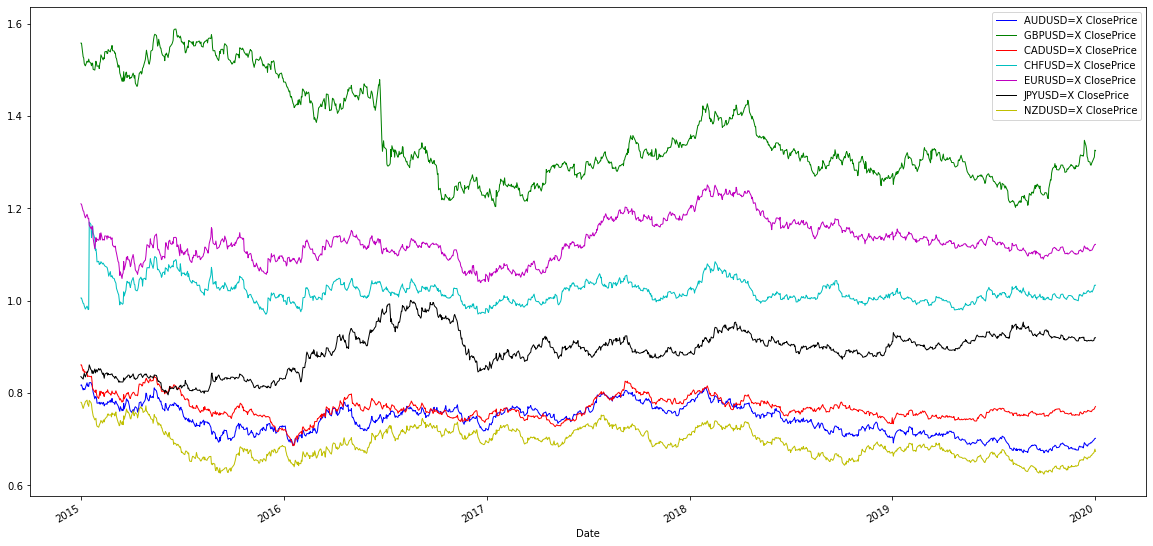

In [72]:
# we visualize the graph
from itertools import cycle
plt.rcParams["figure.figsize"] = (20,10)

color = cycle('bgrcmky')
price_data = pd.DataFrame()

for symbol in symbols:
    mul = 1.0
    label = symbol+' ClosePrice'
    # since the values of usd to yen are too small
    # we multiply it by 100
    if symbol == 'JPYUSD=X':
        mul = 100.0
    price_data = price_data.assign(label = pd.Series(symbols_data[symbol]['Close'] * mul, index = symbols_data[symbol].index))
    ax = price_data['label'].plot(lw = 1.,color = next(color),label = label)
plt.legend()

In [73]:
# we can see that the currencies are all correlatd to each other
# but in differet degrees, for example:
# the pairs CAD-USD, AUD-USD, NZD-USD are most correlated

# now, we want to see the correlation, simple moving average of each pair, and the corresponding price deviation
import statistics as stats
periods = 20 # we use 20-day SMA
price_history = {} # we use dictionary because we have 7 pairs

num_price_dev = [] # look back period of closeprice deviation
price_deviation = {}

num_days = len(symbols_data[trading_pairs].index)
correlation = {}

delta_projected_history = {} # the difference between projected closeprice and the real price per currency

final_delta = [] # the difference between projected closeprice of trading_pairs and the real price 

In [74]:
# we define some parameters for our strategy
# +1: buy, -1: sell, 0: no action
orders = [] 
# positive: long, negative: short, 0: neutral
positions = [] 
# sum of total pnls, both closed and open
pnls = []

# we define buy and sell thresholds
buy_entry = 0.01
sell_entry = -0.01
min_price_move = 0.01
num_shares = 100000 # the number of shares each order
min_profit_to_close = 10 # the close value for open pnl

In [ ]:
# we calculate sma first
for i in range(num_days):
    close_prices = {}
    
    for symbol in symbols: # we loop each pair
        close_prices[symbol] = symbols_data[symbol]['Close'].iloc[i]
        if symbol not in price_history.keys():
            price_history[symbol] = []
            price_deviation[symbol] = []
        
        price_history[symbol].append(close_prices[symbol])
        # we check for sma periods
        if len(price_history[symbol])>periods:
            del(price_history[symbol][0])
        sma = stats.mean(price_history[symbol])
        price_deviation[symbol].append(close_prices[symbol]-sma)
        # since our look back period is 200 days, we check for the length of price deviation
        if len(price_deviation[symbol]) > num_days:
            del(price_deviation[symbol][0])
        
    # now, we want to check the relationship between our own trading pairs and other currency pairs
    # by using covariance and correlationwice
    # we loop t

    # covariance: shows how much two variables differ
    
    projcted_dev_from_sma = {}
    for symbol in symbols:
        if symbol == trading_pairs: # we don't need the correlation to itself
            continue
        correlation_label = trading_pairs + '<-' + symbol
        if correlation_label not in correlation.keys():
            correlation[correlation_label] = []
            delta_projected_history[correlation_label] = []

        # we check the length of projcted_dev_from_sma
        # we need at least two observations to compute correlation and covariance
        if len(price_deviation[symbol]) < 2:
            correlation[correlation_label].append(0)
            delta_projected_history[correlation_label].apend(0)
            continue
        # we calculate correlation and covariance of the price deviation of two trading pairs
        corr = np.corrcoef(price_deviation[trading_pairs],price_deviation[symbol])
        cov_got = pd.Series(price_deviation[trading_pairs]).cov(pd.Series(price_deviation[symbol])) # we 
        # get the covariance between two series
        corr_got = corr[0][1] # the correlation we get between two series
        
        # we append correlation
        correlation[correlation_label].append(corr_got)
        
        # we calculate projected price deviation for finding out delta
        # the projected price deviation will be calculated by cov * price_deviation
        projected_dev = cov_got * price_deviation[symbol][-1] # -1: the latest price deviation
        
        # delta: an estimate of the value of security changes with one dollar changes in its underlying assets
        # here we calculate projected delta: the projected price change - the actually price change
        
        # positive projected delta: price should have moved up more than it should
        # negative projected delta: price should have moved down more than it shoud
        delta_projected = projected_dev - price_deviation[symbol][-1] 
        delta_projected_history[correlation_label].append(delta_projected)
    
    # now we calculate the weight of each correlation pair
    sum_weights = 0 # we use the total weights for the use of normalization

    for symbol in symbols:
        # we skip the targeted trading pair still
        if symbol == trading_pairs:
            continue

        # we keep track of correlation
        correlation_label = trading_pairs + '<-' + symbol
        # why do we use correlation[correlation_label][-1]:
        # we use the latest correlation

        # why absolute numbers: some correlations are negative, but we only look at the weights
        # not whether it is positive or negative
        sum_weights += abs(correlation[correlation_label][-1])

    # we keep track of the total delta for weighing purposes
    final_delta_projected = 0
    close_price = close_prices[symbol]
    # we calculate the final delta now
    for symbol in symbols:
        if symbol == trading_pairs:
            continue

        correlation_label = trading_pairs + '<-' + symbol
        
        # now we weigh the final delta by using correlation
        # we multiply the delta_projected by the correlation value,
        # because we want to use it to weight the delta
        final_delta_projected = abs(correlation[correlation_label][-1]) * delta_projected_history[correlation_label][-1]
        
        # we normalize the final delta by the sum of correlation
        if sum_weights != 0:
            final_delta_projected /= sum_weights
        else:
            final_delta_projected = 0
        final_delta.append(final_delta_projected)